<a href="https://colab.research.google.com/github/SRARNAB7/HDS_5230_07_Arnab/blob/main/Facial_Vgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: absl-py==2.2.2 in c:\users\asutar1\appdata\local\anaconda3\lib\site-packages (from -r requirements.txt (line 1)) (2.2.2)
  Using cached certifi-2025.1.31-py3-none-any.whl.metadata (2.5 kB)
  Using cached charset_normalizer-3.4.1-cp312-cp312-win_amd64.whl.metadata (36 kB)
  Using cached h5py-3.13.0-cp312-cp312-win_amd64.whl.metadata (2.5 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached Markdown-3.7-py3-none-any.whl.metadata (7.0 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached numpy-2.1.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached packaging-24.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached pip-25.0.1-py3-none-any.whl.metadata (3.7 kB)
  Using cached protobuf-5.29.4-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached pygments-2.19.1-py

ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement tensorflow-io-gcs-filesystem==0.31.0 (from versions: none)
ERROR: No matching distribution found for tensorflow-io-gcs-filesystem==0.31.0


In [2]:
import zipfile
import os
zip_path = r'C:\Users\asutar1\Downloads\archive.zip'
extract_path= r'C:\Users\asutar1\Downloads\fer_data'
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

print(f"Files Extracted to:{extract_path}")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\asutar1\\Downloads\\archive.zip'

In [3]:
!pip install tensorflow

  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached grpcio-1.71.0-cp312-cp312-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.9.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached ml_dtypes-0.5.1-cp312-cp312-win_amd64.whl.metadata (22 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using cached optree-0.15.0-cp312-cp312-win_amd64.whl.metadata (49 kB)
  Using cached tenso

In [3]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D,Input,Dense, Dropout
from keras.layers import Flatten,Conv2D,MaxPooling2D,BatchNormalization
import os


In [4]:
train_dir = "C:/Users/asutar1/Downloads/FER_PROJECT/fer_data/train"
test_dir = "C:/Users/asutar1/Downloads/FER_PROJECT/fer_data/test"

In [5]:
image_size=(48,48)
batch_size=64       #key hyperparameter, it refers to the no of training examples used in 1 iteration of updating the models weight
epochs=50

In [6]:

def count_images(dir):
  total_images= 0

  for sub_dir,_,files in os.walk(dir):
    total_images += len(files)

  return total_images

train_images= count_images(train_dir)
test_images= count_images(test_dir)

print(f"Total Training Images:{train_images}")
print(f"Total Testing Images:{test_images}")

Total Training Images:28709
Total Testing Images:7178


In [7]:
def count_images_per_dir(dir):

  for sub_dir,_,files in os.walk(dir):
    total_images = len(files)
    print(f"{sub_dir} contents:{total_images}")

print("Training set images count in each folder")
count_images_per_dir(train_dir)

print("Testing set images count in each folder")
count_images_per_dir(test_dir)


Training set images count in each folder
C:/Users/asutar1/Downloads/FER_PROJECT/fer_data/train contents:0
C:/Users/asutar1/Downloads/FER_PROJECT/fer_data/train\angry contents:3995
C:/Users/asutar1/Downloads/FER_PROJECT/fer_data/train\disgust contents:436
C:/Users/asutar1/Downloads/FER_PROJECT/fer_data/train\fear contents:4097
C:/Users/asutar1/Downloads/FER_PROJECT/fer_data/train\happy contents:7215
C:/Users/asutar1/Downloads/FER_PROJECT/fer_data/train\neutral contents:4965
C:/Users/asutar1/Downloads/FER_PROJECT/fer_data/train\sad contents:4830
C:/Users/asutar1/Downloads/FER_PROJECT/fer_data/train\surprise contents:3171
Testing set images count in each folder
C:/Users/asutar1/Downloads/FER_PROJECT/fer_data/test contents:0
C:/Users/asutar1/Downloads/FER_PROJECT/fer_data/test\angry contents:958
C:/Users/asutar1/Downloads/FER_PROJECT/fer_data/test\disgust contents:111
C:/Users/asutar1/Downloads/FER_PROJECT/fer_data/test\fear contents:1024
C:/Users/asutar1/Downloads/FER_PROJECT/fer_data/tes

In [8]:
#data augumentation for training
train_datagen= ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
   # width_shift_range=0.2,
   # height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [9]:
test_datagen= ImageDataGenerator(rescale=1./255) # 255 color combination

In [10]:
train_generator= train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode= 'grayscale',
    shuffle=True
)

Found 28709 images belonging to 7 classes.


In [11]:
test_generator= train_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode= 'grayscale',
    shuffle= False
)

Found 7178 images belonging to 7 classes.


Data print from the folders with labesl label code sample image with type and code class code 6 label photo print VGG16 model


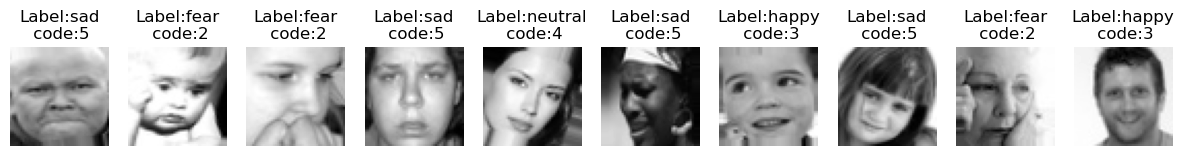

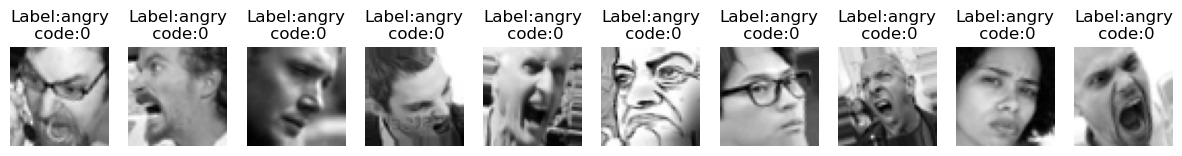

In [12]:
def plot_sample_data(generator,number_samples=10):
  images,labels= next(generator)

  class_indices= generator.class_indices
  #print("Class Indices:",class_indices)
  class_names= list(class_indices.keys())
  #print("Class Names:",class_names)

  plt.figure(figsize=(15,15))

  for i in range(number_samples):
    plt.subplot(1,number_samples,i+1)
    plt.imshow(images[i].reshape(image_size[0],image_size[1]),cmap='grey') # first convert then give color
    label_index= np.argmax(labels[i]) # argmax func returns indices of the max element of the array
    #print(label_index)
    label_name= class_names[label_index]
    plt.title(f'Label:{label_name}\n code:{label_index}')
    plt.axis('off')
  plt.show()

plot_sample_data(train_generator)
plot_sample_data(test_generator)



In [13]:
from keras.optimizers import Adam
#Define Model
base_model= VGG19(weights='imagenet', include_top= False, input_shape= (48,48,3))# in one channel since in gral scale only
#Adding custom layers on top
input_tensor= Input(shape= (48,48,1))
layers=Conv2D(3,(1,1),padding='same')(input_tensor)
layers= Model(inputs= input_tensor,outputs=layers)(input_tensor)
base_model_output= base_model(layers)
layers= base_model_output
layers= GlobalAveragePooling2D()(layers)
layers= Dense(512,activation='relu')(layers) # 256 no of neurons, relu for non linear
layers= BatchNormalization()(layers)
layers= Dropout(0.5)(layers)
layers= Dense(256,activation='relu')(layers) # 256 no of neurons, relu for non linear
layers= BatchNormalization()(layers)
layers= Dropout(0.5)(layers)
predictions = Dense(7,activation='softmax')(layers) #7 neurons since 7 class and softmax when multiclass classification

model_vgg19= Model(inputs=input_tensor,outputs=predictions)
for layer in base_model.layers[:-4]:
  layer.trainable=False

model_vgg19.compile(optimizer= Adam(learning_rate= 0.0001),loss= 'categorical_crossentropy', metrics= ['accuracy'])
model_vgg19.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 48, 48, 3)      │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 1, 1, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,423,245 (77.91 MB)

 Trainable params: 7,476,749 (28.52 MB)

 Non-trainable params: 12,946,496 (49.39 MB)

In [26]:
history_vgg19= model_vgg19.fit(
    train_generator,
    steps_per_epoch= train_generator.samples // batch_size,
    validation_data=  test_generator,
    validation_steps = test_generator.samples // batch_size,
    epochs = 50
)


C:\Users\asutar1\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 1900s 4s/step - accuracy: 0.1638 - loss: 2.8296 - val_accuracy: 0.1423 - val_loss: 5.6363
Epoch 2/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 14:42 2s/step - accuracy: 0.2188 - loss: 2.6477

C:\Users\asutar1\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


448/448 ━━━━━━━━━━━━━━━━━━━━ 106s 233ms/step - accuracy: 0.2188 - loss: 2.6477 - val_accuracy: 0.1413 - val_loss: 5.5542
Epoch 3/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 1274s 3s/step - accuracy: 0.1978 - loss: 2.4829 - val_accuracy: 0.2595 - val_loss: 2.3476
Epoch 4/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 152s 334ms/step - accuracy: 0.2344 - loss: 2.2904 - val_accuracy: 0.2573 - val_loss: 2.3007
Epoch 5/50
102/448 ━━━━━━━━━━━━━━━━━━━━ 14:27 3s/step - accuracy: 0.2291 - loss: 2.2978

KeyboardInterrupt: 

In [16]:
model_vgg19.save('C:/Users/asutar1/Downloads/FER_PROJECT/my_model_vgg19.h5')

In [15]:
from tensorflow.keras.models import load_model
path= r"my_model_vgg19.h5"
model_vgg19= load_model(path)

In [16]:
test_loss, test_accuracy = model_vgg19.evaluate(test_generator)
print(f'Test Accuracy:{test_accuracy*100:.2f}%')
print(f'Test Loss:{test_loss*100:.2f}%')

C:\Users\asutar1\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.4885 - loss: 1.5959
Test Accuracy:54.32%
Test Loss:141.64%


plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(model_vgg19.history['accuracy'],label= 'Training Accuracy')
plt.plot(model_vgg19.history['val_accuracy'],label= 'Validation Accuracy')
plt.title('Training and VAlidation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history_vgg19.history['loss'],label= 'Training Loss')
plt.plot(history_vgg19.history['val_loss'],label= 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
Y_pred= model_vgg19.predict(test_generator)
y_pred= np.argmax(Y_pred,axis=1)
print('Confusion matrix')
print(confusion_matrix(test_generator.classes,y_pred))

print('Classification Report')
target_column= list(train_generator.class_indices.keys())
print(classification_report(test_generator.classes,y_pred,target_names=target_column))



113/113 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step
Confusion matrix
[[ 386    9   99  150  170  108   36]
 [  24   45   10   10   13    8    1]
 [ 105    3  355  109  151  193  108]
 [  52    5   44 1335  211   81   46]
 [  76    2   78  173  716  150   38]
 [ 101    6  151  184  321  458   26]
 [  32    1   67   69   73   11  578]]
Classification Report
              precision    recall  f1-score   support

       angry       0.50      0.40      0.45       958
     disgust       0.63      0.41      0.49       111
        fear       0.44      0.35      0.39      1024
       happy       0.66      0.75      0.70      1774
     neutral       0.43      0.58      0.50      1233
         sad       0.45      0.37      0.41      1247
    surprise       0.69      0.70      0.69       831

    accuracy                           0.54      7178
   macro avg       0.54      0.51      0.52      7178
weighted avg       0.54      0.54      0.53      7178



In [22]:
!pip install opencv-python

   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---- ----------------------------------- 4.2/39.5 MB 25.2 MB/s eta 0:00:02
   ---------------- ----------------------- 16.3/39.5 MB 42.6 MB/s eta 0:00:01
   ---------------------------- ----------- 27.8/39.5 MB 47.6 MB/s eta 0:00:01
   ---------------------------------------  39.3/39.5 MB 49.0 MB/s eta 0:00:01
   ---------------------------------------- 39.5/39.5 MB 44.0 MB/s eta 0:00:00


In [29]:
import tensorflow
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2

image_size=(48,48)
emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

def predict_emotion_from_camera(model, target_size=(48, 48)):
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Could not open camera. Check camera connection and permissions.") 
        return None, None

    ret, frame = cap.read()
    if not ret:
        print("Error: Could not capture frame. Camera may be opened but frame capture failed.")
        cap.release()
        return None, None

    cap.release()

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized_frame = cv2.resize(gray_frame, target_size)
    img_array = image.img_to_array(resized_frame)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array, verbose=0) 
    emotion_index = np.argmax(prediction)
    predicted_emotion_name = emotion_labels[emotion_index]
    return predicted_emotion_name, emotion_index


predicted_emotion, emotion_index = predict_emotion_from_camera(model_vgg19, target_size=image_size)

if predicted_emotion:
    print(f'Predicted emotion from camera: {predicted_emotion} (Index: {emotion_index})')
else:
    print("Emotion prediction failed.")

Predicted emotion from camera: Sad (Index: 4)


In [27]:
import tensorflow
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2


#h5_model_path = r'E:\EMOTION_RECOG\my_vgg19_model.h5'  
#model_vgg19 = load_model(h5_model_path)

image_size = (48, 48)
emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def predict_emotion_realtime_face_detect(model, target_size=(48, 48)):
    """
    Opens the system camera, detects faces in each frame, and predicts
    emotions on detected faces in real-time video.

    Args:
        model: Trained Keras model for emotion recognition.
        target_size: Target image size for the emotion model.
    """
    cap = cv2.VideoCapture(0)  

    if not cap.isOpened():
        print("Error: Could not open camera.")
        return

    while(cap.isOpened()):
        ret, frame = cap.read()
        if not ret:
            break

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 

        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        for (x, y, w, h) in faces:
            face_roi_gray = gray_frame[y:y + h, x:x + w] 
            resized_face = cv2.resize(face_roi_gray, target_size) 
            img_array = image.img_to_array(resized_face) 
            img_array = np.expand_dims(img_array, axis=0) 
            img_array = img_array / 255.0 

            prediction = model.predict(img_array) 
            emotion_index = np.argmax(prediction) 
            predicted_emotion = emotion_labels[emotion_index] 

            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2) 
            cv2.putText(frame, predicted_emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2) 

        cv2.imshow('Real-time Face Emotion Recognition', frame) 

        if cv2.waitKey(1) & 0xFF == ord('q'): 
            break

    cap.release()
    cv2.destroyAllWindows()

predict_emotion_realtime_face_detect(model_vgg19, target_size=image_size)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 